In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [14]:
(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = (x_train - 0.5) / 0.5   # [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)

batch_size = 128
train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.shuffle(10000).batch(batch_size)


In [15]:
def build_generator():
    model = keras.Sequential([
        keras.Input(shape=(latent_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dense(512, activation="relu"),
        layers.Dense(1024, activation="relu"),
        layers.Dense(28*28*1, activation="tanh"),
        layers.Reshape((28,28,1))
    ])
    return model


In [16]:
def build_discriminator():
    model = keras.Sequential([
        keras.Input(shape=(28,28,1)),   # 👈 First layer
        layers.Flatten(),
        layers.Dense(512),
        layers.LeakyReLU(0.2),
        layers.Dense(256),
        layers.LeakyReLU(0.2),
        layers.Dense(1)
    ])
    return model


In [17]:
bce = keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

gen_optimizer = keras.optimizers.Adam(0.0002, beta_1=0.5)
disc_optimizer = keras.optimizers.Adam(0.0002, beta_1=0.5)


In [18]:
@tf.function
def train_step(real_images):
    noise = tf.random.normal([tf.shape(real_images)[0], latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [19]:
epochs = 20

for epoch in range(epochs):
    for image_batch in train_ds:
        g_loss, d_loss = train_step(image_batch)

    print(f"Epoch {epoch+1}, Generator Loss: {g_loss:.4f}, Discriminator Loss: {d_loss:.4f}")


Epoch 1, Generator Loss: 0.8873, Discriminator Loss: 1.1345
Epoch 2, Generator Loss: 1.0506, Discriminator Loss: 1.2006
Epoch 3, Generator Loss: 0.6507, Discriminator Loss: 1.4178
Epoch 4, Generator Loss: 0.8688, Discriminator Loss: 1.2674
Epoch 5, Generator Loss: 0.8572, Discriminator Loss: 1.2260
Epoch 6, Generator Loss: 0.9022, Discriminator Loss: 1.1953
Epoch 7, Generator Loss: 0.6982, Discriminator Loss: 1.2016
Epoch 8, Generator Loss: 0.9740, Discriminator Loss: 1.2614
Epoch 9, Generator Loss: 0.8402, Discriminator Loss: 1.2411
Epoch 10, Generator Loss: 0.6782, Discriminator Loss: 1.3606
Epoch 11, Generator Loss: 0.4444, Discriminator Loss: 1.5909
Epoch 12, Generator Loss: 0.8167, Discriminator Loss: 1.3087
Epoch 13, Generator Loss: 0.7956, Discriminator Loss: 1.3262
Epoch 14, Generator Loss: 0.8473, Discriminator Loss: 1.2576
Epoch 15, Generator Loss: 0.7617, Discriminator Loss: 1.3708
Epoch 16, Generator Loss: 0.9315, Discriminator Loss: 1.3155
Epoch 17, Generator Loss: 0.7869,

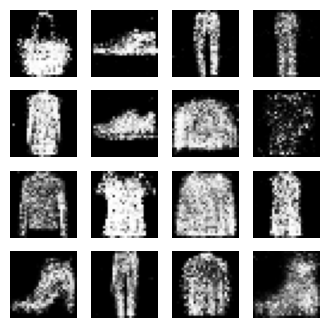

In [20]:
def show_images():
    noise = tf.random.normal([16, latent_dim])
    images = generator(noise, training=False)
    images = (images + 1) / 2.0

    plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(images[i,:,:,0], cmap="gray")
        plt.axis("off")
    plt.show()

show_images()
